In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
user_info =pd.read_csv("user_info.csv")  
conversion = pd.read_csv("conversion_table.csv") 
data = user_info.merge(conversion, how='inner', on='user_id')

# Train/Test split

In [15]:
#There are only two invalid records. We can remove them.
data[data['age']>110]
data = data[data['age']<110]

In [16]:
#create a dummy variable to indicate missing value
data['country'] = data['country'].fillna("missing_country")

In [17]:
#dummy variables for the categorical ones
data_dummy = pd.get_dummies(data, drop_first=True)
data_dummy

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,country_missing_country,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,0,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,0,0,0
316196,27,1,6,0,0,0,1,0,1,0
316197,25,0,4,0,0,0,0,0,0,0
316198,22,0,4,0,0,0,1,0,0,1


In [18]:
#split into train and test set
train, test = train_test_split(data_dummy, test_size = 0.2)

# logistic regression

In [19]:
#add intercept
train_reg = train
test_reg = test

train_reg['intercept'] = 1
test_reg['intercept'] = 1
train_reg

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,country_missing_country,source_Direct,source_Seo,intercept
164765,38,1,6,0,0,0,1,0,0,1,1
204166,22,1,9,0,0,0,1,0,0,1,1
138128,35,1,8,0,0,0,0,0,0,1,1
56381,30,0,1,0,0,0,1,0,1,0,1
292598,23,1,3,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
261518,19,1,7,0,1,0,0,0,0,1,1
289365,33,1,4,0,0,0,0,1,0,1,1
58281,39,0,2,0,0,0,1,0,0,1,1
2244,41,1,3,0,0,0,1,0,0,1,1


In [20]:
train_cols = train_reg.drop('converted', axis=1)
test_cols = test_reg.drop('converted', axis=1)

In [21]:
logit = sm.Logit(train_reg['converted'], train_cols)
output = logit.fit()

Optimization terminated successfully.
         Current function value: 0.040147
         Iterations 11


In [22]:
output_table = pd.DataFrame(dict(coefficients = output.params, SE = output.bse, z = output.tvalues, p_values = output.pvalues))
#get coefficients and pvalues
print(output_table)

                         coefficients        SE           z       p_values
age                         -0.074263  0.002675  -27.763492  1.197615e-169
new_user                    -1.758202  0.040100  -43.845387   0.000000e+00
total_pages_visited          0.758775  0.006987  108.593851   0.000000e+00
country_Germany              3.935545  0.170861   23.033556  2.150057e-117
country_UK                   3.726495  0.159497   23.364052  9.919710e-121
country_US                   3.344719  0.156023   21.437360  5.991726e-102
country_missing_country      0.160234  0.290393    0.551784   5.810963e-01
source_Direct               -0.245029  0.054875   -4.465249   7.997580e-06
source_Seo                  -0.040856  0.044717   -0.913648   3.609018e-01
intercept                  -10.428120  0.189103  -55.145307   0.000000e+00


In [23]:
#keep significant variables
output_table.loc[output_table['p_values'] < 0.05].sort_values("coefficients", ascending=False)

,coefficients,SE,z,p_values
country_Germany,3.935545,0.170861,23.033556,2.150057e-117
country_UK,3.726495,0.159497,23.364052,9.919710e-121
country_US,3.344719,0.156023,21.437360,5.991726e-102
total_pages_visited,0.758775,0.006987,108.593851,0.000000e+00
age,-0.074263,0.002675,-27.763492,1.197615e-169
source_Direct,-0.245029,0.054875,-4.465249,7.997580e-06
new_user,-1.758202,0.040100,-43.845387,0.000000e+00
intercept,-10.428120,0.189103,-55.145307,0.000000e+00


In [24]:
#train accuracy 
train_hat = output.predict(train_cols)
train_pred = list(map(round,train_hat))
(train_pred  == train_reg['converted']).sum()/len(train_reg['converted'])

0.9863771851453601

In [25]:
# test accuracy
test_hat = output.predict(test_cols)
test_pred = list(map(round,test_hat))
(test_pred == test_reg['converted']).sum()/len(test_reg['converted']) 

0.9854048070841239

- The large coefficients of country dummy variables are an result of taking China as reference level. It is clear from exploratory data analysis that China has a much lower conversion rate compared to other countries
- The test accuracy and train accuracy are similar so there is no need to use regularization. With regularization, we can indeed increase model performance by a little bit, but the focus of this project is to extract insights from data.
- total_pages_visited is also an important one. However, it is probably the least actionable. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Total pages viewed tend to be correlated with conversion 
- Using logistic regression, we are able to improve the prediction accuracy from 97% to approximately 98.5%. However, logistic regression cannot explore non-linear relationship. It is unlikely that continuous variable such as age has a monotonic relationship with the target variable
- To explore non-linear relationship as well as identify the most marketable segments, we will use tree-based method next.


# Random forest 

In [26]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9848393804505096 
 OOB Confusion Matrix 
         0     1
0  243671  1205
1    2630  5452


In [27]:
#OOB error and test error are pretty similar
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9840607210626185 
 Test Set Confusion Matrix 
        0     1
0  60824   300
1    708  1408


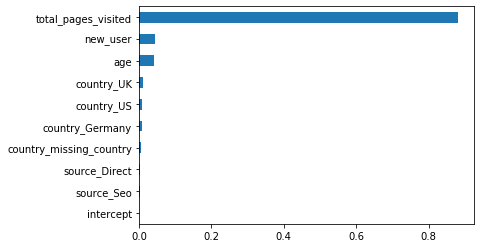

In [34]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Total pages visited is the most important one. However, it's also the least actionable metric. We should rebuild the RF without that variable. Given that classes are heavily unbalanced and we don’t have the powerful variable anymore, change the weights so that the model is able to capture some events from class 1

In [35]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8911360779259798 
 OOB Confusion Matrix 
         0      1
0  221777  23099
1    4439   3643


In [36]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8897058823529411 
 Test Set Confusion Matrix 
        0     1
0  55365  5759
1   1216   900


In [37]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# max depth in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# min number of samples required to split a node
min_samples_split = [2, 5, 10]
# min number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 5]}


In [38]:
# use random grid to search for best combination of hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train.drop('converted', axis=1), train['converted'])

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42)

In [39]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 70}

In [45]:

rf = RandomForestClassifier(n_estimators=100, min_samples_split= 10,min_samples_leaf = 3, 
                            max_features='auto', max_depth = 70, oob_score=True,class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8900173151274124 
 OOB Confusion Matrix 
         0      1
0  221485  23391
1    4430   3652


In [46]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8880297280202404 
 Test Set Confusion Matrix 
        0     1
0  55243  5881
1   1200   916


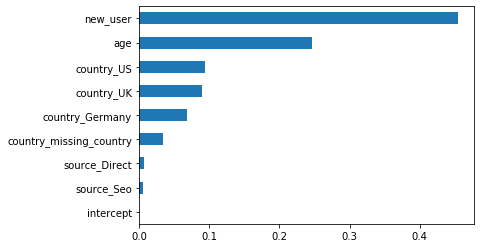

In [47]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Even though continuous varaible tends to have more feature importance in sklearn tree-based model, new user still has more importance than age. It means new_user is really important. Source-related dummies don’t seem to matter at all.

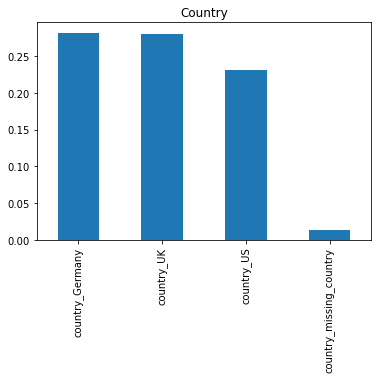

In [50]:
# build partial dependence plot
from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US','country_missing_country'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

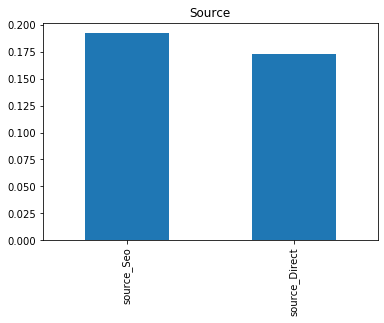

In [49]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

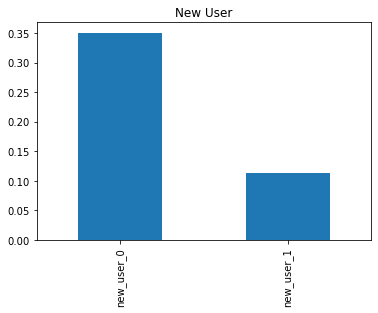

In [51]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

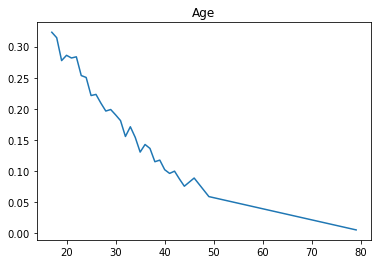

In [52]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

In [53]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree


In [54]:
# build a decision tree and check the most important segments
dt = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
dt.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=2,
                       min_impurity_decrease=0.001)

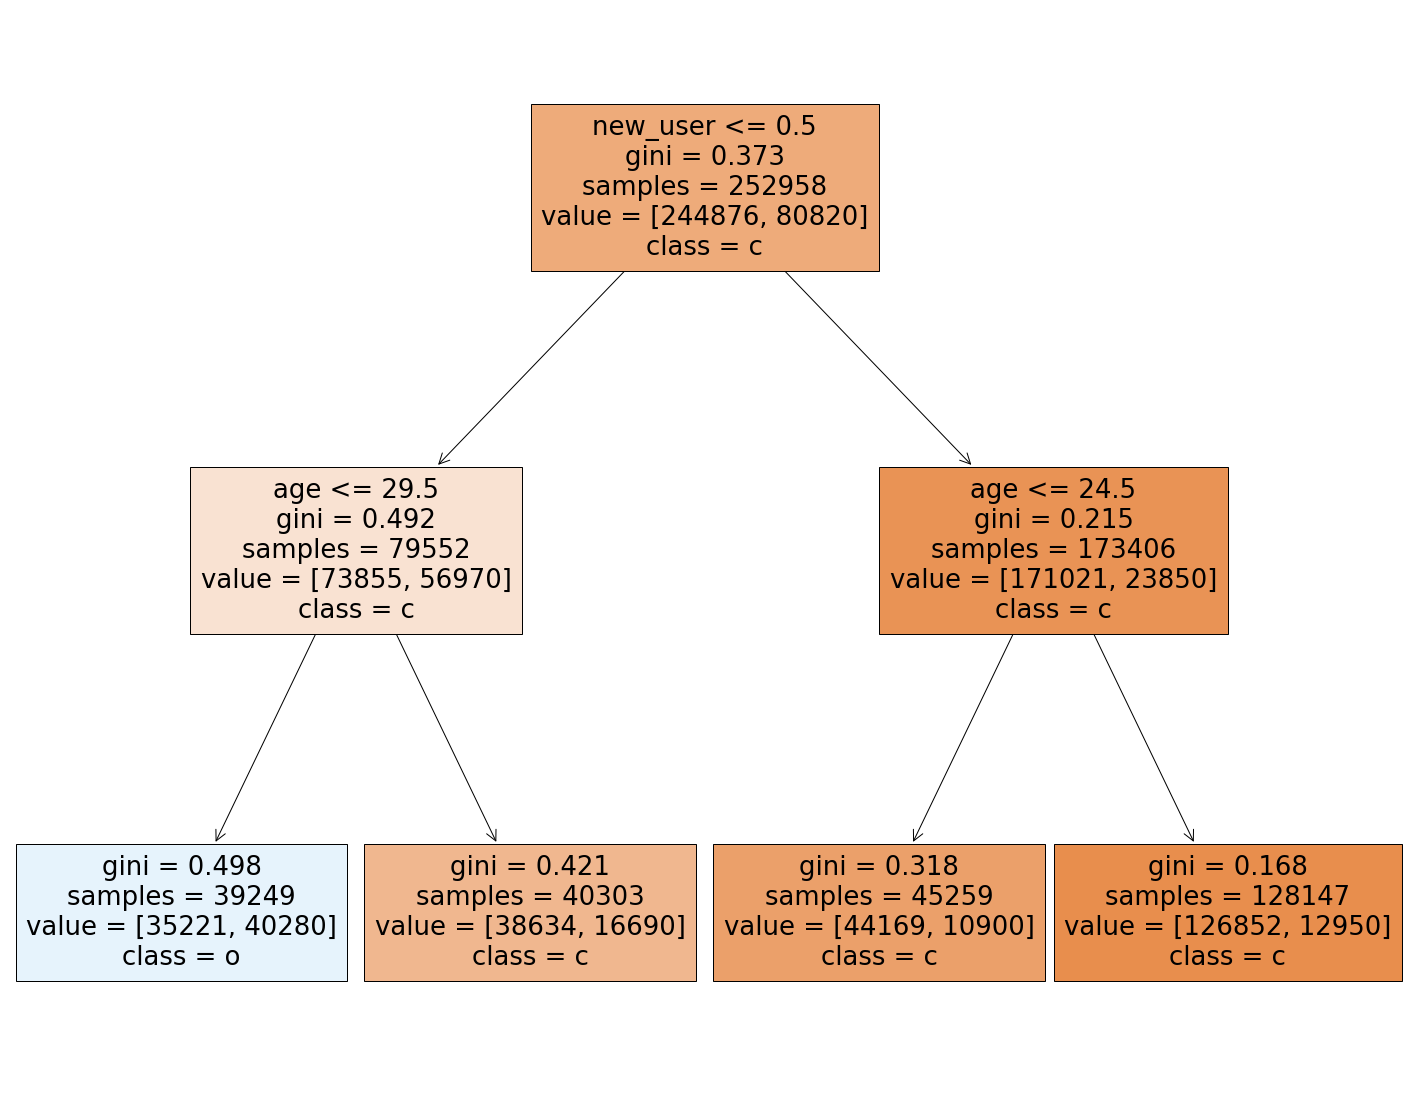

In [55]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns,  
                   class_names='converted',
                   filled=True)

In [23]:
# build a random forest to separate frequent customers from inactive users
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True,class_weight={0:2, 1:1})
rf.fit(train.drop(['converted', 'total_pages_visited','new_user'], axis=1), train['new_user'])


RandomForestClassifier(class_weight={0: 2, 1: 1}, max_features=3,
                       oob_score=True)

In [24]:
#OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_
)

OOB accuracy is 0.8290016524482324


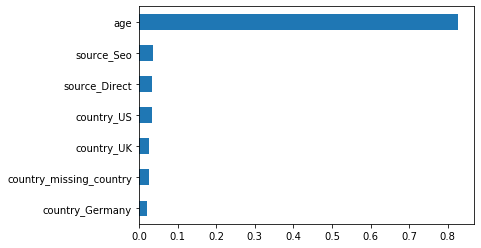

In [25]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited','new_user'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [31]:
data.groupby(['country']).size()

country
China               58999
Germany             13055
UK                  48449
US                 178092
missing_country     17603
dtype: int64

# Conclusion


- Returning customers are much better than new users and young users have a higher retention rate than old users. Also, most young users come from search engine. Therefore, we should optimize SEO keyword towards young users. Also, targeted emails with offers to bring them back to the site could be a good idea to try.


- Taken users in China as a reference level, users in Germany, UK, and US have much higher conversion rate. This could be an indicator of bad translation or bad UI design with the Chinese version of the site. Given how many users are based in China, fixing this should be a top priority. 


- Other than China, users in Germany, UK, and US have similar conversion rate, with Germany being the best. However, the site has the least amount of users from Germany compared to other countries. Attaracting more users from Germany could another goal for the marketing team. 


- The site works well for people under 30. From ~30 y/o conversion clearly starts dropping. Oone possible cause if that the UI design is not friendly to old users. To solve this problem, a good actionable metric to work on is conversion rate for people >=30 yr old. 


